### Simple examples
(Диффуры которые легко интерпретировать)

In [1]:
import torch
import pyro
from pyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt

In [2]:
import os
import sys
import inspect

# insert root dir into sys
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
root_dir = os.path.dirname(currentdir)
# print(root_dir)

if root_dir not in sys.path:
     sys.path.insert(0, root_dir)

In [3]:
import sim5_hw as sm

In [4]:
# efficiency matrix:
# (will be transposed)
U = 0.1*torch.ones((8, 8))
U[0][:3] = torch.tensor([0.7, 0.8, 0.3])
U[1][2:] = torch.tensor([0.3, 0.5, 0.9, 0.9, 0.9, 0.2])
U[2][:4] = torch.tensor([0.9, 0.9, 0.5, 0.2])
U[3][2:-1] = torch.tensor([0.9, 0.5, 0.7, 0.7, 0.7])
U[4][:] = torch.tensor([0.6, 0.7, 0.9, 0.9, 0.5, 0.5, 0.5, 0.2])
U[5][:] = torch.tensor([0.9, 0.9, 0.6, 0.4, 0.1, 0.1, 0.1, 0.1])
U[6][4:] = torch.tensor([0.9, 0.9, 0.9, 0.5])
U[7][4:] = torch.tensor([0.9, 0.9, 0.9, 0.7])


Model specification:

In [5]:
    A_spec = {
        "decision_matrix": None,
        "units": {

            # needed only if there is neither types nor counts given:
            # "possible_types": [0, 1, 2, 3, 4],
            # "chosen_count": 3,
            # "types": [0, 1, 4],
            "types": [0, 4],

            "counts": torch.tensor([3, 4]).type(torch.float),
            # maximal amount of units to sample for any type
            # must be given if "counts" not: 
            "max_count": 4,
        },
        "goal": lambda x, y: (y <= 0).all(),
        ## "goal": lambda x, y: y[1] <= 0 and y[2] <= 0
        # "goal": lambda x, y: y[0] <= 0 and y[1] <= 0 and x[-1] > 2
    }
    B_spec = {
        "decision_matrix": None,
        "units": {
            "types": [1, 2, 3],
            "counts": torch.tensor([2, 4,  2]).type(torch.float)
        },
        "goal": lambda x, y: (x <= 0).all() # and y[2] >= 2
        # "goal": lambda x, y: x[1] <= 0 and x[-1] <= 0,  # and y[2] >= 2
    }

    sim_spec = {
        "agents": {"A": A_spec, "B": B_spec},

        "T": 30,
        "dt": 0.5,
        # "dt": 0.5,
        "init_factor": -110.0,

        "U": U,

        # choose side A (i.e. want A to win):
        "scores": [
            {
                "test": lambda goalA, goalB: goalA and not goalB,
                "once": False,
                "factor": 0,
                # will be exited once happend, factor been be overriden
                "exit": True
            },
            {
                "test": lambda goalA, goalB: not goalA and goalB,
                "once": False,
                "factor": -1000,
                # will be exited once happend, factor been be overriden
                "exit": True
            },
            {
                "test": lambda goalA, goalB: not goalA and not goalB,
                # only once from all times will factor been used  
                "once": True,
                "factor": 10,
                "exit": False
            }
        ] 
    }


In [6]:
def run_test_and_show(sim_spec):
    '''Run the model with given spec.'''
    losses = []
    ehandler = sm.test_mk_model(sim_spec, losses, False, False)

    sm.show_model_states_context(
        ehandler, ["x", "y", "Ua", "Ub", "Ax", "Ay", "events_to_check"])
    sm.show_model_states_context(
        ehandler, ["utypes"],
        observation_name="sample_space_of_a_utypes")
    sm.show_model_states_context(
            ehandler, ["ucounts"],
            observation_name="counts_of_x0")

    sm.show_model_trace(ehandler, ["x0", "Ax_T", "y0", "Ay_T"])
    


In [7]:
run_test_and_show(sim_spec)


observations state_context::

x
tensor([0., 0.])

y
tensor([0.0000, 0.5214, 0.8763])

Ua
tensor([[0.8000, 0.7000],
        [0.3000, 0.9000],
        [0.1000, 0.9000]])

Ub
tensor([[0.1000, 0.9000, 0.1000],
        [0.9000, 0.1000, 0.7000]])

Ax
tensor([[0.4000, 0.7016],
        [0.5446, 0.2209],
        [0.0553, 0.0774]])

Ay
tensor([[0.6768, 0.6338, 0.6884],
        [0.3232, 0.3662, 0.3116]])

events_to_check
OrderedDict([('goalA', tensor(False)), ('goalB', tensor(True)), ('goalAoverB', True), ('exit?', None)])

observations state_context::
no observations to show

observations state_context::
no observations to show

trace:

Ax
tensor([[0.4000, 0.7016],
        [0.5446, 0.2209],
        [0.0553, 0.0774]])

event_error_factor:
tensor(-1000)


In [11]:
mcmc, losses = sm.test_mcmc(40, sim_spec, mdbg=False, edbg=False)

Sample: 100%|██████████| 80/80 [04:57,  3.72s/it, step size=8.44e-01, acc. prob=0.553]


Collect result (solution):

In [12]:
sim_spec = sm.update_spec(sim_spec, mcmc, idx=-1, side="A", dbg=False)
sim_spec['agents']['A']

{'decision_matrix': tensor([[0.3231, 0.2458],
         [0.3918, 0.3978],
         [0.2850, 0.3564]]),
 'goal': <function __main__.<lambda>>,
 'units': {'counts': tensor([3., 4.]), 'max_count': 4, 'types': [0, 4]}}

Collect factor (error) and others params:

In [23]:
run_test_and_show(sim_spec)



observations state_context::

x
tensor([0., 0.])

y
tensor([1.0135, 2.6730, 0.9439])

Ua
tensor([[0.8000, 0.7000],
        [0.3000, 0.9000],
        [0.1000, 0.9000]])

Ub
tensor([[0.1000, 0.9000, 0.1000],
        [0.9000, 0.1000, 0.7000]])

Ax
tensor([[0.3231, 0.2458],
        [0.3918, 0.3978],
        [0.2850, 0.3564]])

Ay
tensor([[0.0135, 0.7854, 0.1983],
        [0.9865, 0.2146, 0.8017]])

events_to_check
OrderedDict([('goalA', tensor(False)), ('goalB', tensor(True)), ('goalAoverB', True), ('exit?', None)])

observations state_context::
no observations to show

trace:

event_error_factor:
tensor(-1000)


Now let give him the matrix Ay:

In [25]:
Ay = torch.tensor([[0.0135, 0.7854, 0.1983],
                   [0.9865, 0.2146, 0.8017]])

In [27]:
sim_spec["agents"]["A"]["decision_matrix"]=None
sim_spec["agents"]["B"]["decision_matrix"]=Ay
sim_spec

{'T': 30,
 'U': tensor([[0.7000, 0.8000, 0.3000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.3000, 0.5000, 0.9000, 0.9000, 0.9000, 0.2000],
         [0.9000, 0.9000, 0.5000, 0.2000, 0.1000, 0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.9000, 0.5000, 0.7000, 0.7000, 0.7000, 0.1000],
         [0.6000, 0.7000, 0.9000, 0.9000, 0.5000, 0.5000, 0.5000, 0.2000],
         [0.9000, 0.9000, 0.6000, 0.4000, 0.1000, 0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000, 0.1000, 0.9000, 0.9000, 0.9000, 0.5000],
         [0.1000, 0.1000, 0.1000, 0.1000, 0.9000, 0.9000, 0.9000, 0.7000]]),
 'agents': {'A': {'decision_matrix': None,
   'goal': <function __main__.<lambda>>,
   'units': {'counts': tensor([3., 4.]), 'max_count': 4, 'types': [0, 4]}},
  'B': {'decision_matrix': tensor([[0.0135, 0.7854, 0.1983],
           [0.9865, 0.2146, 0.8017]]),
   'goal': <function __main__.<lambda>>,
   'units': {'counts': tensor([2., 4., 2.]), 'types': [1, 2, 3]}}},
 'dt': 0.5,
 '

and try again:

In [30]:
# will stick here
# mcmc, losses = sm.test_mcmc(40, sim_spec, mdbg=False, edbg=False)

Now we do not give him counts and let find it himself:

In [32]:
 A_spec1 = {
        "decision_matrix": None,
        "units": {

            # needed only if there is neither types nor counts given:
            # "possible_types": [0, 1, 2, 3, 4],
            # "chosen_count": 3,
            # "types": [0, 1, 4],
            "types": [0, 4],

            # "counts": torch.tensor([3, 4]).type(torch.float),
            # maximal amount of units to sample for any type
            # must be given if "counts" not: 
            "max_count": 7,
        },
        "goal": lambda x, y: (y <= 0).all(),
        ## "goal": lambda x, y: y[1] <= 0 and y[2] <= 0
        # "goal": lambda x, y: y[0] <= 0 and y[1] <= 0 and x[-1] > 2
    }
sim_spec["agents"]["A"]=A_spec1
sim_spec

{'T': 30,
 'U': tensor([[0.7000, 0.8000, 0.3000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.3000, 0.5000, 0.9000, 0.9000, 0.9000, 0.2000],
         [0.9000, 0.9000, 0.5000, 0.2000, 0.1000, 0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.9000, 0.5000, 0.7000, 0.7000, 0.7000, 0.1000],
         [0.6000, 0.7000, 0.9000, 0.9000, 0.5000, 0.5000, 0.5000, 0.2000],
         [0.9000, 0.9000, 0.6000, 0.4000, 0.1000, 0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000, 0.1000, 0.9000, 0.9000, 0.9000, 0.5000],
         [0.1000, 0.1000, 0.1000, 0.1000, 0.9000, 0.9000, 0.9000, 0.7000]]),
 'agents': {'A': {'decision_matrix': None,
   'goal': <function __main__.<lambda>>,
   'units': {'max_count': 7, 'types': [0, 4]}},
  'B': {'decision_matrix': tensor([[0.0135, 0.7854, 0.1983],
           [0.9865, 0.2146, 0.8017]]),
   'goal': <function __main__.<lambda>>,
   'units': {'counts': tensor([2., 4., 2.]), 'types': [1, 2, 3]}}},
 'dt': 0.5,
 'init_factor': -110.0,
 'scor

In [33]:
mcmc, losses = sm.test_mcmc(40, sim_spec, mdbg=False, edbg=False)

Sample: 100%|██████████| 80/80 [04:11,  3.14s/it, step size=1.49e-01, acc. prob=0.693]


In [34]:
sim_spec = sm.update_spec(sim_spec, mcmc, idx=-1, side="A", dbg=False)
sim_spec['agents']['A']

{'decision_matrix': tensor([[0.4816, 0.2262],
         [0.0034, 0.3921],
         [0.5151, 0.3816]]),
 'goal': <function __main__.<lambda>>,
 'units': {'counts': tensor([4.8629, 4.1483]),
  'max_count': 7,
  'types': [0, 4]}}

In [35]:
run_test_and_show(sim_spec)



observations state_context::

x
tensor([0.0000, 1.3180])

y
tensor([0., 0., 0.])

Ua
tensor([[0.8000, 0.7000],
        [0.3000, 0.9000],
        [0.1000, 0.9000]])

Ub
tensor([[0.1000, 0.9000, 0.1000],
        [0.9000, 0.1000, 0.7000]])

Ax
tensor([[0.4816, 0.2262],
        [0.0034, 0.3921],
        [0.5151, 0.3816]])

Ay
tensor([[0.0135, 0.7854, 0.1983],
        [0.9865, 0.2146, 0.8017]])

events_to_check
OrderedDict([('goalA', tensor(True)), ('goalB', tensor(False)), ('goalAoverB', True), ('exit?', None)])

observations state_context::
no observations to show

trace:

event_error_factor:
tensor(0)


Ay is arbitrary (minimax problem):

In [23]:
 A_spec1 = {
        "decision_matrix": None,
        "units": {

            # needed only if there is neither types nor counts given:
            # "possible_types": [0, 1, 2, 3, 4],
            # "chosen_count": 3,
            # "types": [0, 1, 4],
            "types": [0, 4],

            # "counts": torch.tensor([3, 4]).type(torch.float),
            # maximal amount of units to sample for any type
            # must be given if "counts" not: 
            "max_count": 5,
            "min_count": 2,
        },
        "goal": lambda x, y: (y <= 0).all(),
        ## "goal": lambda x, y: y[1] <= 0 and y[2] <= 0
        # "goal": lambda x, y: y[0] <= 0 and y[1] <= 0 and x[-1] > 2
    }
sim_spec["agents"]["A"]=A_spec1
sim_spec["agents"]["B"]["decision_matrix"]=None

sim_spec

{'T': 30,
 'U': tensor([[0.7000, 0.8000, 0.3000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.3000, 0.5000, 0.9000, 0.9000, 0.9000, 0.2000],
         [0.9000, 0.9000, 0.5000, 0.2000, 0.1000, 0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.9000, 0.5000, 0.7000, 0.7000, 0.7000, 0.1000],
         [0.6000, 0.7000, 0.9000, 0.9000, 0.5000, 0.5000, 0.5000, 0.2000],
         [0.9000, 0.9000, 0.6000, 0.4000, 0.1000, 0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000, 0.1000, 0.9000, 0.9000, 0.9000, 0.5000],
         [0.1000, 0.1000, 0.1000, 0.1000, 0.9000, 0.9000, 0.9000, 0.7000]]),
 'agents': {'A': {'decision_matrix': None,
   'goal': <function __main__.<lambda>>,
   'units': {'max_count': 5, 'min_count': 2, 'types': [0, 4]}},
  'B': {'decision_matrix': None,
   'goal': <function __main__.<lambda>>,
   'units': {'counts': tensor([2., 4., 2.]), 'types': [1, 2, 3]}}},
 'dt': 0.5,
 'init_factor': -110.0,
 'scores': [{'exit': True,
   'factor': 0,
   'once': Fal

In [24]:
mcmc, losses = sm.test_mcmc(20, sim_spec, mdbg=False, edbg=False)
# mcmc, losses = sm.test_mcmc(40, sim_spec, mdbg=False, edbg=False)

Sample: 100%|██████████| 40/40 [09:55, 14.90s/it, step size=5.66e-08, acc. prob=0.284]


In [25]:
sim_spec = sm.update_spec(sim_spec, mcmc, idx=-1, side="A", dbg=False)
sim_spec['agents']['A']

{'decision_matrix': tensor([[0.3272, 0.2379],
         [0.3979, 0.4300],
         [0.2750, 0.3321]]),
 'goal': <function __main__.<lambda>>,
 'units': {'counts': tensor([3.7098, 3.1311]),
  'max_count': 5,
  'min_count': 2,
  'types': [0, 4]}}

In [26]:
run_test_and_show(sim_spec)


observations state_context::

x
tensor([0.0000, 0.6641])

y
tensor([0., 0., 0.])

Ua
tensor([[0.8000, 0.7000],
        [0.3000, 0.9000],
        [0.1000, 0.9000]])

Ub
tensor([[0.1000, 0.9000, 0.1000],
        [0.9000, 0.1000, 0.7000]])

Ax
tensor([[0.3272, 0.2379],
        [0.3979, 0.4300],
        [0.2750, 0.3321]])

Ay
tensor([[0.8187, 0.4312, 0.4503],
        [0.1813, 0.5688, 0.5497]])

events_to_check
OrderedDict([('goalA', tensor(True)), ('goalB', tensor(False)), ('goalAoverB', True), ('exit?', None)])

observations state_context::
no observations to show

observations state_context::
no observations to show

trace:

event_error_factor:
tensor(0)


In [46]:
def run_tests_and_collect_factors(count, sim_spec):
    '''Run the model `count` times with given sim.'''
    factors = []
    losses = []
    for i in range(count):
        ehandler = sm.test_mk_model(sim_spec, losses, False, False)
        factor = ehandler.trace.nodes["event_error_factor"]
        factor_value = factor["value"]
        factor_log = factor["fn"].log_prob(factor_value)
        factors.append(factor_log)

    factors = torch.cat([factor.unsqueeze(0) for factor in factors]).type(torch.long)
    print("factors:")
    print(factors)
    print("losses:")
    print(losses)

    plt.hist(factors, bins=15)
    plt.title("factors")
    plt.show()
    return factors

In [ ]:
run_tests_and_collect_factors(10, sim_spec)

units types not given

In [ ]:
    A_spec1 = {
        "decision_matrix": None,
        "units": {

            # needed only if there is neither types nor counts given:
            # "possible_types": [0, 3, 4],
            # "chosen_count": 3,
            "types": [0, 3, 4],
            # "types": [0, 4],

            # "counts": torch.tensor([3, 4]).type(torch.float),
            # maximal amount of units to sample for any type
            # must be given if "counts" not: 
            # "max_count": 3,
            "max_count": [2, 4, 3],
            "min_count": [1, 2, 1]
        },
        "goal": lambda x, y: (y <= 0).all(),
        ## "goal": lambda x, y: y[1] <= 0 and y[2] <= 0
        # "goal": lambda x, y: y[0] <= 0 and y[1] <= 0 and x[-1] > 2
    }

sim_spec["agents"]["A"]=A_spec1
B_spec1 = {
   "decision_matrix": None,
    "units": {
       "types": [1, 2, 3],
        "counts": torch.tensor([2, 4,  3]).type(torch.float)
    },
    "goal": lambda x, y: (x <= 0).all() # and y[2] >= 2
    # "goal": lambda x, y: x[1] <= 0 and x[-1] <= 0,  # and y[2] >= 2
}
sim_spec["agents"]["B"]=B_spec1
sim_spec

In [24]:
run_test_and_show(sim_spec)


observations state_context::

x
tensor([0.4023, 0.0000, 0.0000])

y
tensor([0.2300, 0.0000, 0.0000])

Ua
tensor([[0.8000, 0.1000, 0.7000],
        [0.3000, 0.9000, 0.9000],
        [0.1000, 0.5000, 0.9000]])

Ub
tensor([[0.1000, 0.9000, 0.1000],
        [0.5000, 0.2000, 0.5000],
        [0.9000, 0.1000, 0.7000]])

Ax
tensor([[0.2631, 0.1317, 0.0786],
        [0.2705, 0.4112, 0.6338],
        [0.4664, 0.4571, 0.2875]])

Ay
tensor([[0.0034, 0.2218, 0.4453],
        [0.4912, 0.4887, 0.2736],
        [0.5054, 0.2895, 0.2811]])

events_to_check
OrderedDict([('goalA', tensor(False)), ('goalB', tensor(False)), ('goalAoverB', False), ('exit?', None)])

observations state_context::
no observations to show

observations state_context::

ucounts
tensor([1.5509, 3.8956, 2.7964])

trace:

x0
tensor([1.5509, 3.8956, 2.7964])

Ax
tensor([[0.2631, 0.1317, 0.0786],
        [0.2705, 0.4112, 0.6338],
        [0.4664, 0.4571, 0.2875]])

event_error_factor:
tensor(-100.)


In [25]:
mcmc, losses = sm.test_mcmc(40, sim_spec, mdbg=False, edbg=False)

Sample: 100%|██████████| 80/80 [26:04, 19.56s/it, step size=1.52e-21, acc. prob=0.262]


In [26]:
sim_spec['agents']['A']

{'decision_matrix': None,
 'goal': <function __main__.<lambda>>,
 'units': {'max_count': [3, 4, 3], 'min_count': [1, 2, 1], 'types': [0, 3, 4]}}

In [27]:
sim_spec = sm.update_spec(sim_spec, mcmc, idx=-1, side="A", dbg=False)
sim_spec['agents']['A']

{'decision_matrix': tensor([[0.2943, 0.1214, 0.4863],
         [0.2755, 0.5353, 0.0878],
         [0.4302, 0.3433, 0.4259]]),
 'goal': <function __main__.<lambda>>,
 'units': {'counts': tensor([1.0136, 2.8959, 2.7661]),
  'max_count': [3, 4, 3],
  'min_count': [1, 2, 1],
  'types': [0, 3, 4]}}

In [31]:
sim_spec['agents']['A']["counts"]=[1, 3, 2]

In [32]:
run_test_and_show(sim_spec)


observations state_context::

x
tensor([0.0000, 1.3508, 1.3085])

y
tensor([0., 0., 0.])

Ua
tensor([[0.8000, 0.1000, 0.7000],
        [0.3000, 0.9000, 0.9000],
        [0.1000, 0.5000, 0.9000]])

Ub
tensor([[0.1000, 0.9000, 0.1000],
        [0.5000, 0.2000, 0.5000],
        [0.9000, 0.1000, 0.7000]])

Ax
tensor([[0.2943, 0.1214, 0.4863],
        [0.2755, 0.5353, 0.0878],
        [0.4302, 0.3433, 0.4259]])

Ay
tensor([[0.2425, 0.3835, 0.6104],
        [0.5242, 0.1323, 0.2480],
        [0.2334, 0.4842, 0.1416]])

events_to_check
OrderedDict([('goalA', tensor(True)), ('goalB', tensor(False)), ('goalAoverB', True), ('exit?', None)])

observations state_context::
no observations to show

observations state_context::
no observations to show

trace:

event_error_factor:
tensor(0)


factors:
tensor([-1000,     0, -1000, -1000, -1000,  -100,     0, -1000, -1000,     0,
        -1000, -1000,  -100, -1000, -1000, -1000, -1000,     0, -1000, -1000,
            0,  -100,  -100,  -100,  -100,  -100, -1000,  -100, -1000, -1000])
losses:
[]


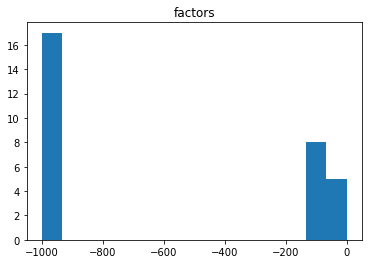

In [50]:
factors = run_tests_and_collect_factors(30, sim_spec)

In [40]:
factors

tensor([-1000, -1000, -1000,  -100,     0,     0, -1000,     0,     0,     0,
        -1000, -1000,  -100,     0, -1000,  -100,  -100,     0,  -100, -1000,
        -1000, -1000,     0,  -100,     0, -1000, -1000,  -100, -1000, -1000])

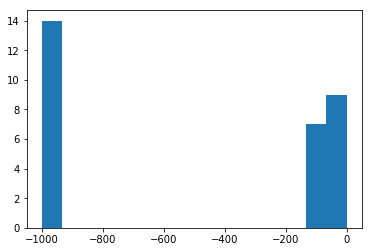